# Ethereum Predictions with ARIMA

## Data Exploration

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

C:\Users\bosullivan1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('USDT_ETH.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
df.head()

,open,high,low,close,quoteVolume,volume,weightedAverage
date,,,,,,,
2015-08-11,0.660,1.14,0.550000,1.10,251.517082,242.975973,0.966042
2015-08-12,1.050,1.40,0.900001,1.38,404.344781,476.807211,1.179210
2015-08-13,1.300,2.15,1.300000,2.14,347.837491,586.286854,1.685519
2015-08-14,2.140,2.15,2.140000,2.15,24.919395,53.476714,2.145988
2015-08-15,1.625,2.20,1.150000,1.50,33.627559,53.223246,1.582727


In [3]:
df.tail()

,open,high,low,close,quoteVolume,volume,weightedAverage
date,,,,,,,
2018-04-04,415.623191,417.000000,370.000000,378.400210,18398.928348,7.123378e+06,387.162655
2018-04-05,378.487519,388.000000,366.500000,381.500000,6537.060047,2.461477e+06,376.541904
2018-04-06,382.500000,385.000000,362.607400,369.000000,5018.129910,1.861465e+06,370.947856
2018-04-07,369.000000,395.138332,369.000000,385.369066,5630.327803,2.153962e+06,382.564314
2018-04-08,385.369066,403.951535,383.706647,396.690146,5379.372884,2.126251e+06,395.260016


## Monthly Forecasting

We will predict Ethereum prices by months.

In [4]:
btc_month = df.resample('M').mean()

### Stationarity check and Seasonal decomposition

If a time series is stationary, it implies the lack of broad trends (changes in mean and variance over time) in the data. This is important as a consideration in time series forecasting.

The p-value below indicates that the series is not stationary with 99.85% confidence.

Dickey–Fuller test: p=0.998582


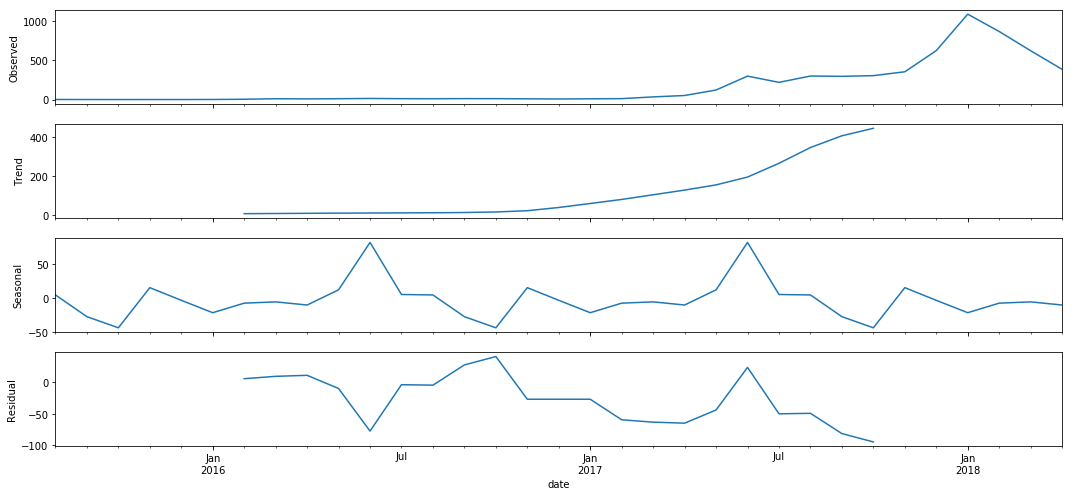

In [5]:
#seasonal_decompose(btc_month.close, freq=12).plot()
seasonal_decompose(btc_month.close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close)[1])
plt.show()

### Box-Cox Transformation 

We will use the Box-Cox transformation to suppress some of the variance.

Sometimes after applying Box-Cox with a particular value of lambda the process may look stationary. It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary, diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to to remove polynomial trends or seasonal trends respectively. After that, the result might be an ARMA model that is stationary. If diagnostics confirm the orders p an q for the ARMA model, the AR and MA parameters can then be estimated.

The p-value below indicates that series is still not stationary.

In [6]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.578436


### Differencing 

Another pre-processing step is differencing the data until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations.

#### Seasonal differentiation 

One method of differencing data is seasonal differencing, which involves computing the difference between an observation and the corresponding observation in the previous year.

The p-value below indicates that series is still not stationary.

In [7]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.958532


In [8]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.593183


#### Regular differentiation 

Sometimes it may be necessary to difference the data a second time to obtain a stationary time series, which is referred to as second order differencing.

The p-value below indicates that series is close to stationary as the computed p-value is near the significance level alpha = 0.05

Dickey–Fuller test: p=0.067147


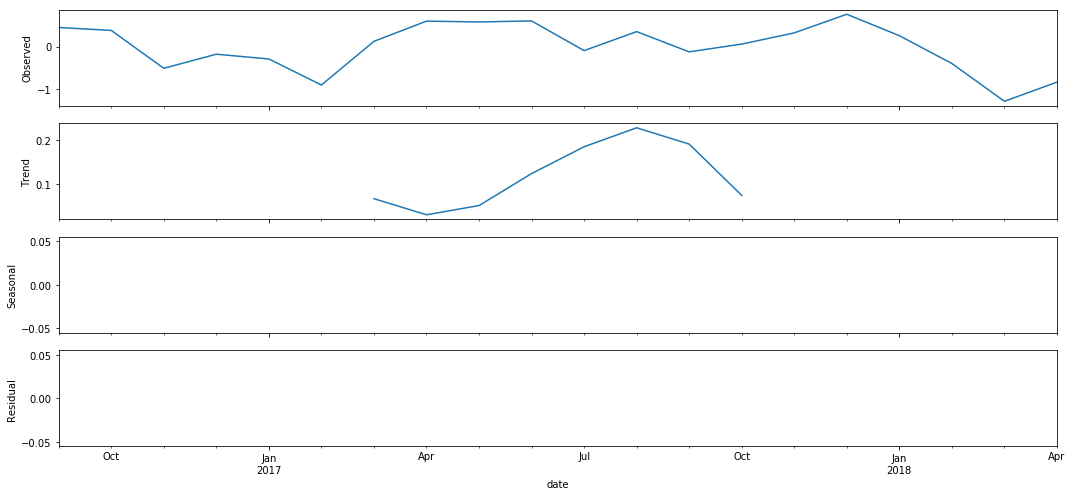

In [9]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

#### Autocorrelation 

Autocorrelation summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create a autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the residuals.

There is a positive correlation with the first 10 lags that is perhaps significant for the first 2-3 lags. A good starting point for the AR parameter of the model may be 3. So we will try out autocorrelation on the differences.

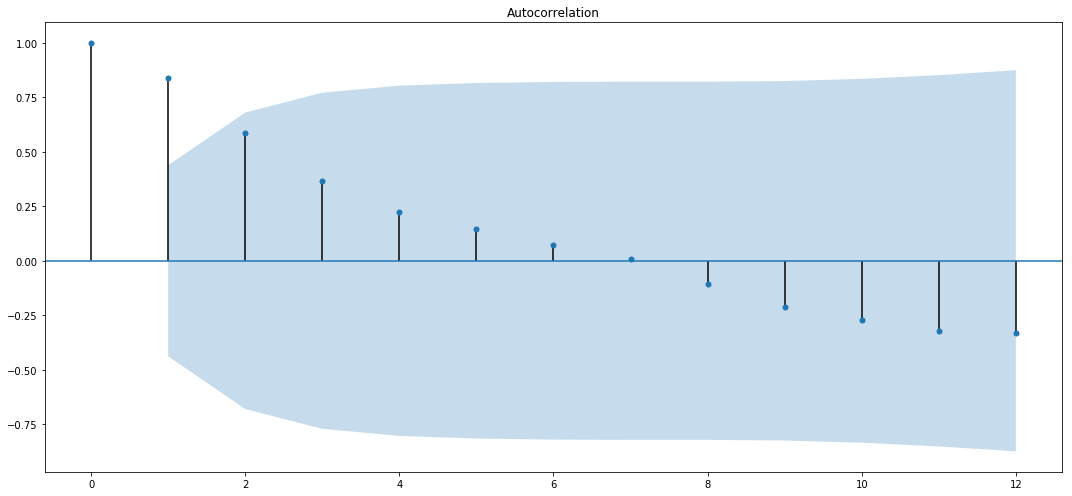

In [10]:
#autocorrelation_plot(btc_month.close)
plot_acf(btc_month.close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

There are not many spikes in the plots below outside the insignificant zone (shaded) so there may not be enough information available in the residuals to be extracted by AR and MA models.

There may be a seasonal component available in the residuals at the lags of quarters (3 months) represented by spikes at these intervals. But probably not significant.

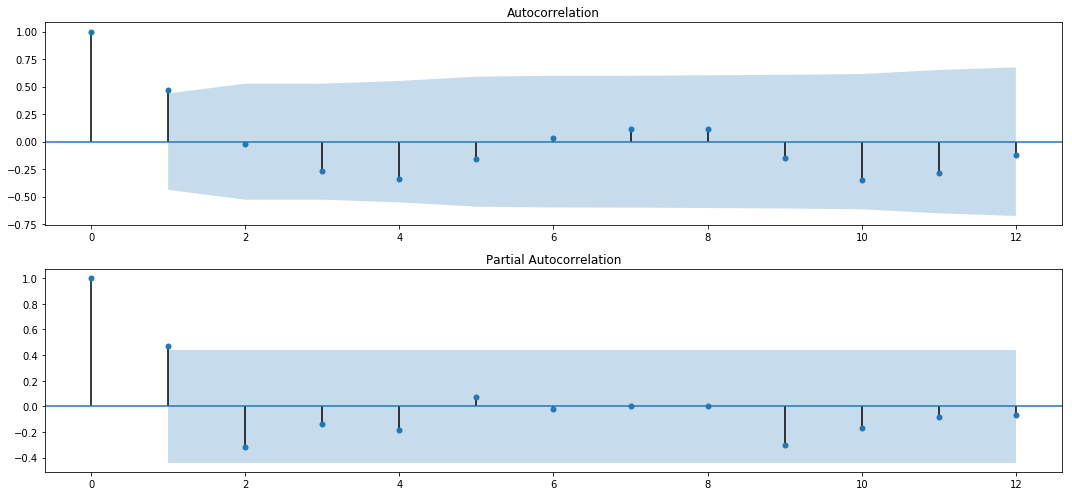

In [11]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

## ARIMA Model

AutoRegressive Integrated Moving Average

ARIMA models are denoted with the notation ARIMA(p, d, q). These parameters account for seasonality, trend, and noise in datasets:

p - the number of lag observations to include in the model, or lag order. (AR)
d - the number of times that the raw observations are differenced, or the degree of differencing. (I)
q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

### Parameter Selection

We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [12]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0)


In [13]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters        aic
2     (1, 0)  35.693060
0     (0, 1)  37.217316
5     (2, 0)  37.577113
3     (1, 1)  37.581318
1     (0, 2)  38.467996


### Analysis of Results 

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [14]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   33
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -15.847
Date:                Sun, 15 Apr 2018   AIC                             35.693
Time:                        13:43:53   BIC                             38.686
Sample:                    08-31-2015   HQIC                            36.700
                         - 04-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4661      0.137      3.398      0.001       0.197       0.735
sigma2         0.1564      0.045      3.492      0.000       0.069       0.244
Ljung-Box (Q):                       30.66   Jarque-

In [15]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.958532


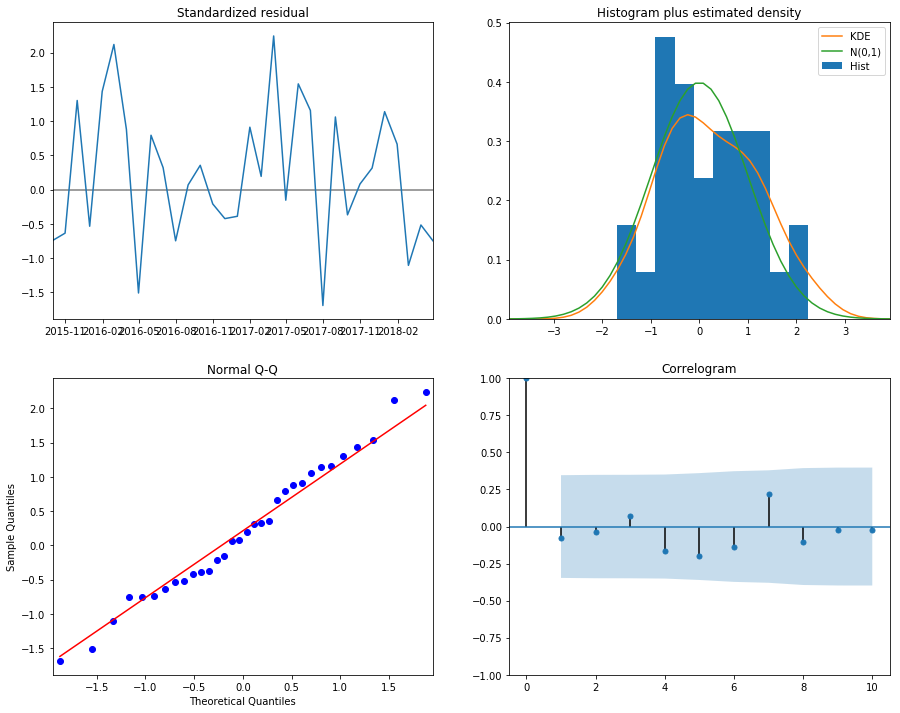

In [16]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

### Prediction

In [17]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

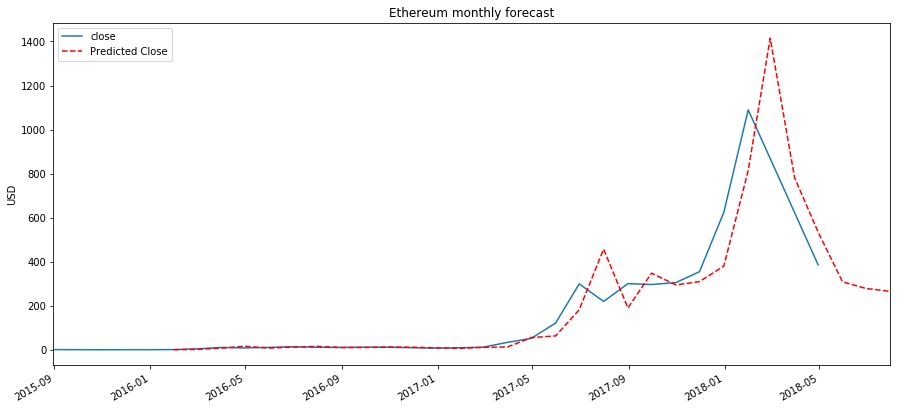

In [27]:
# Prediction
btc_month_pred = btc_month[['close']]
#date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
#             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
#             datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), datetime(2018, 7, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2016, 1, 31), end=datetime(2018, 7, 31)), lmbda)

plt.figure(figsize=(15,7))
btc_month_pred.close.plot()
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Ethereum monthly forecast')
plt.ylabel('USD')
plt.show()

### SARIMAX Model

Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

We didn't expect the Ethereum data to display any seasonality but apparently it does display slight seasonality. 

#### Parameter Selection
The same process of parameter selection for seasonal ARIMA. For each combination we fit a new seasonal ARIMA model with SARIMAX() and assess its overall quality.

In [28]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

bad parameter combination: (0, 0, 0, 0)
bad parameter combination: (2, 1, 0, 0)
bad parameter combination: (2, 1, 0, 1)
bad parameter combination: (2, 1, 1, 0)
bad parameter combination: (2, 1, 1, 1)
bad parameter combination: (2, 1, 2, 0)
bad parameter combination: (2, 1, 2, 1)


### Analysis of Results

In [29]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
18  (1, 0, 0, 1)  42.298740
21  (1, 0, 2, 0)  42.801057
22  (1, 0, 2, 1)  42.825815
6   (0, 1, 0, 1)  42.850260
10  (0, 1, 2, 1)  43.055777
                                 Statespace Model Results                                
Dep. Variable:                         close_box   No. Observations:                   33
Model:             SARIMAX(1, 1, 0)x(0, 1, 1, 4)   Log Likelihood                 -18.149
Date:                           Sun, 15 Apr 2018   AIC                             42.299
Time:                                   14:03:58   BIC                             46.788
Sample:                               08-31-2015   HQIC                            43.809
                                    - 04-30-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

In [30]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.958532


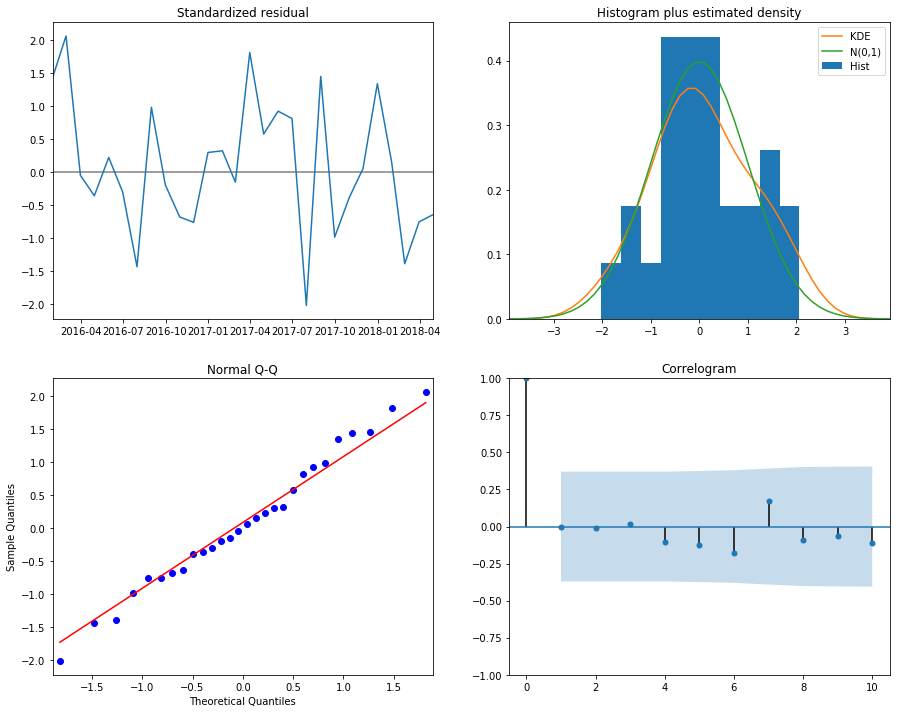

In [31]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

Dickey–Fuller test:: p=0.958532


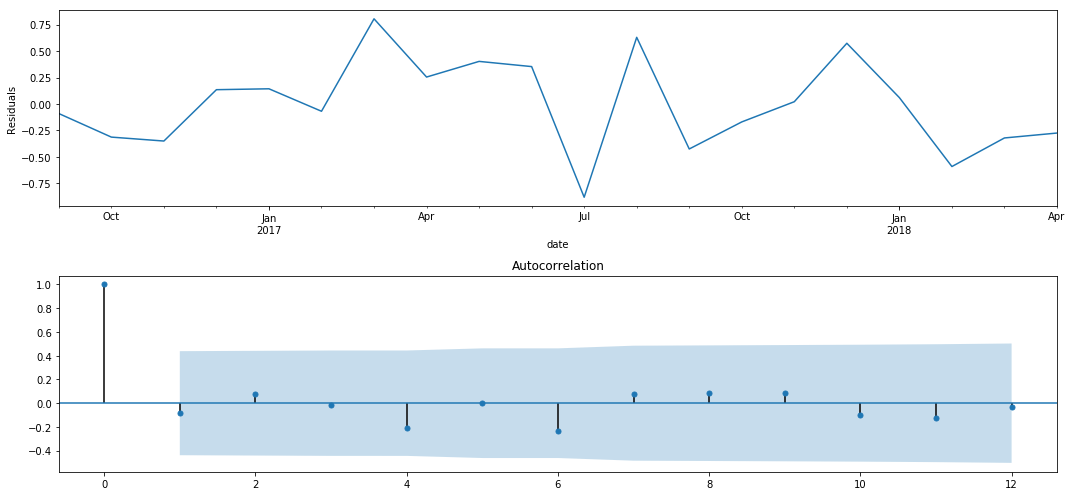

In [32]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags=12, ax=ax)

print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

### Prediction

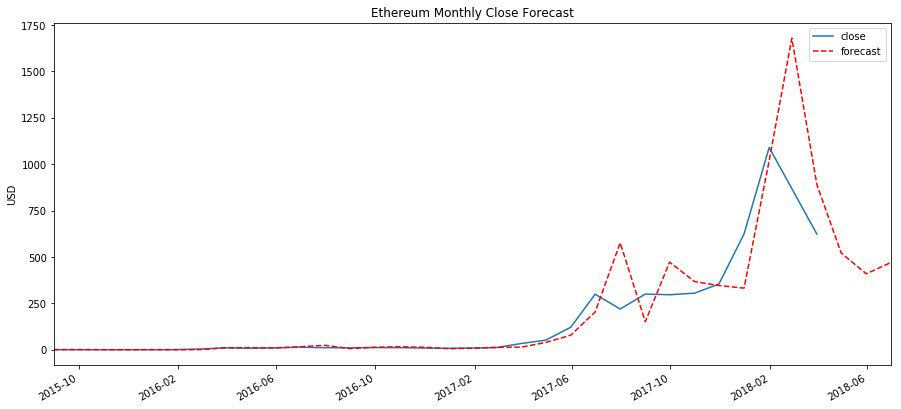

In [33]:
# Prediction
btc_month2 = btc_month[['close']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)

plt.figure(figsize=(15,7))
btc_month2.close.plot()
btc_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Ethereum Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('Ethereum_monthly_forecast.png')
plt.show()

### Validation 

A simple indicator of how accurate out forecast is is the root mean square error (RMSE).

In [34]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2015-09-01':'2017-01-01'].close

# Compute the root mean square error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 3.92



computing the dynamic forecasts and confidence intervals from mid 2017 onwards

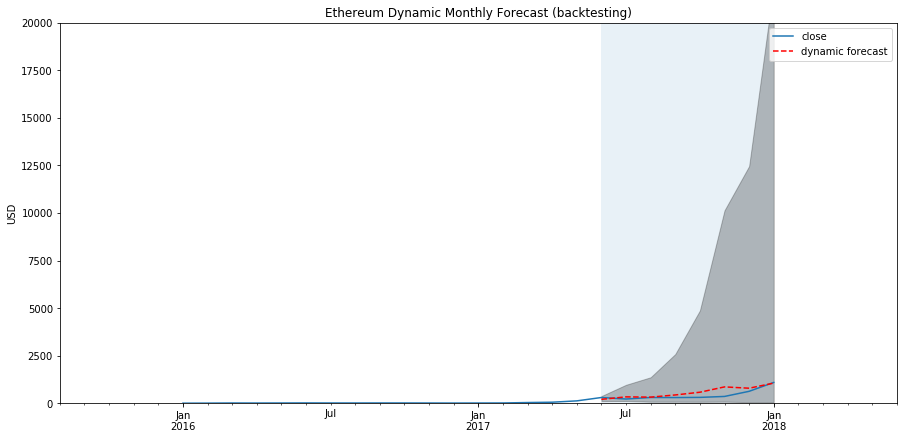

In [35]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-06-30')
t2 = pd.to_datetime('2018-01-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,20000))

btc_month2.close['2016':'2018-01'].plot(label='close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Ethereum Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

seems ok but maybe do further checking..

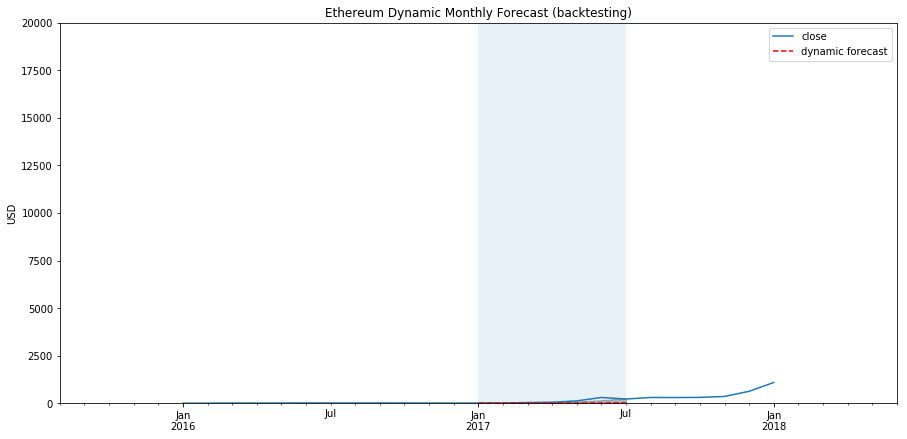

In [36]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2017-01-31')
t2 = pd.to_datetime('2017-07-31')
btc_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,20000))

btc_month2.close['2016':'2018-01'].plot(label='close')
btc_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title('Ethereum Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

Not too bad, maybe overfitting?